In [ ]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
# import imageio as imio
import PIL.Image as pi
import opensimplex as sim

used = [200, 220, 240, 1, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176, 180, 184, 188]
print(len(used))
print(sorted(used))
complete = [x for x in range(256)]
print(list(filter(lambda x: x not in used, complete)))


# im = imio.imread('D:\steam\steamapps\common\SpaceEngineers\Content\Data\PlanetDataFiles\EarthLike\\front_mat.png')
im = pi.open('D:\steam\steamapps\common\SpaceEngineers\Content\Data\PlanetDataFiles\Moon\\up_mat.png')
print(im.mode)
data = np.asarray(im)
blue = data[...,2]
print(blue.shape)
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(blue[:,:])
hist = np.array([0] * 256)
for b in blue.reshape([-1]):
    hist[b] += 1
hist, counts = np.unique(blue, return_counts=True)
print(hist)
print(counts)
hist = {i:v for i,v in zip(hist, counts)}
print(hist)
print(2048 * 2048 - hist[255])

def count_resource(resource, values):
    accum = 0
    for res in values:
        print(res, hist.get(res, 0))
        accum += hist.get(res, 0)
    print(resource + ':', accum)
    
count_resource('iron', (1, 4, 8, 12, 16, 20))
count_resource('nickel', (24, 28, 32, 36, 40, 44))
count_resource('silicon', (48, 52, 56, 60, 64, 68))
count_resource('cobalt', (72, 76, 80, 84, 88, 92, 156, 160, 164))
count_resource('silver', (96, 100, 104, 108, 112, 116))
count_resource('magnesium', (120, 124, 128))
count_resource('ice', (132, 136, 140, 144, 148, 152))
count_resource('gold', (168, 172, 176, 180, 184, 188))

In [ ]:
osm = sim.OpenSimplex()
height = 2048
width = 2048
add_freqs = (3, 5, 7)
small_sub_freqs = (11, 15, 23)
med_sub_freqs=(15, 23, 31)
large_sub_freqs = (23, 31, 43)
add_values = ((-70, 220), (-30, 50), (100, 88))
addmap = np.zeros((len(add_values), height, width), dtype=np.float)
submap = np.zeros((height, width), dtype=np.float)

for f in sub_freqs:
    for y in range(height):
        for x in range(width):
            submap[x, y] += osm.noise2d(x/f, y/f)
resultmaps = list()   
for iv, v in enumerate(add_values):
    for f in add_freqs:
        for y in range(height):
            for x in range(width):
                 addmap[iv, x, y] += osm.noise2d((x+v[0])/f, (y+v[1])/f)

    preresult = addmap[iv,...] - submap
    preresult = np.interp(preresult, (preresult.min(), preresult.max()), (0, 1))
    resultmaps.append(preresult)
resultmap = np.stack(resultmaps)
print(resultmap.min(), resultmap.max())
# noisemap /= len(freqs)
# print(noisemap.min(), noisemap.max())
# distmap = np.zeros((height, width), dtype=np.float)
# for y in range(height):
#     yoff = y - 15
#     for x in range(width):
#         xoff = x - 15
#         distmap[y,x] += math.sqrt(xoff**2 + yoff**2)

# distmap /= distmap.max()
# mergedmap = noisemap - distmap
# mergedmap = np.interp(mergedmap, (mergedmap.min(), mergedmap.max()), (0, 1))
# print(mergedmap.min(), mergedmap.max())



In [ ]:
def estimate_thresholds(src):
    thresholds = list()
    fsrc = np.reshape(src, (src.shape[0], -1))
    for i in range(fsrc.shape[0]):
        ssrc = np.sort(fsrc[i, ...])
        print(ssrc[-6000])
        thresholds.append(ssrc[-6000])
    return thresholds

def threshold(src):
    thresholds = estimate_thresholds(src)
    old_shape = src.shape
    fsrc = np.reshape(src, (old_shape[0],-1))
    print(fsrc.shape)
    dst = np.zeros_like(fsrc)
    for ci, cv in enumerate(thresholds):
        dst[ci,...] = np.fromiter((y if y > cv else 0 for y in fsrc[ci,...]), dtype=src.dtype)
    return dst.reshape(old_shape)

# estimate_thresholds(resultmap)
# thresholds = [0.82, 0.83, 0.81]
# print(thresholds)
# qresultmap = threshold(resultmap, thresholds)
qresultmap = threshold(resultmap)
print('sum:', qresultmap.reshape((-1)).sum())
print(qresultmap.min(), resultmap.max())
print(qresultmap.shape)
print(qresultmap[0,...].sum(), qresultmap[1,...].sum(), qresultmap[2,...].sum())
finalmap = np.zeros(qresultmap.shape[1:],dtype=np.uint8)
for y in range(qresultmap.shape[2]):
    for x in range(qresultmap.shape[1]):
        value = 0
        for v in range(1, qresultmap.shape[0]):
            if qresultmap[v,x,y] > qresultmap[value,x,y]:
                value = v
        finalmap[x,y] = 0 if qresultmap[value,x,y] == 0 else value + 1
        
print(finalmap.sum())
fig, ax = plt.subplots(figsize=(14, 14))
ax.imshow(finalmap)
# ax[0,0].imshow(finalmap[:,:])
# ax[0,1].imshow(submap)
# ax[1,0].imshow(resultmap[1,...])
# ax[1,1].imshow(resultmap[2,...])

In [ ]:
plt.hist(finalmap.reshape((-1)), bins=4)

In [135]:
%matplotlib inline
import math
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as pi
import opensimplex as sim
def get_sub_noise(height, width, octaves):

    osm = sim.OpenSimplex()
    submaps = np.zeros((len(octaves), height, width), dtype=np.float)
    for oi, o in enumerate(octaves):
        print(o)
        for y in range(height):
            for x in range(width):
                submaps[oi, x, y] += osm.noise2d(x/o, y/o)
    submapdict = {o: submaps[oi] for oi, o in enumerate(octaves)}
    return submapdict    

def generate_offsets(value_count, octave_count, size):
    import random
    random.seed(1234)
    rng = lambda: random.randint(0, size)
    offsets = list()
    for i in range(value_count):
        offset = tuple((rng(), rng()) for _ in range(octave_count))
        offsets.append(offset)

    return offsets

def get_ore_map(height, width, worldmap_dict, add_octaves, sub_octaves, amplitudes, offsets):
    result = np.zeros((height, width), dtype=np.float)
    for oi, o in enumerate(add_octaves):
        ofs = offsets[oi]
        result += worldmap_dict[o][ofs[0]:ofs[0]+height, ofs[1]:ofs[1]+width] * amplitudes[oi]
    for oi, o in enumerate(sub_octaves):
        ofs = offsets[oi]
        result -= worldmap_dict[o][ofs[0]:ofs[0]+height, ofs[1]:ofs[1]+width] * amplitudes[oi]
        #result -= worldmap_dict[o][:height,:width] * amplitudes[oi] * 0.5
    return np.interp(result, (result.min(), result.max()), (0, 1))

def get_ore_map_2(height, width, worldmap_dict, add_octaves, sub_noise, amplitudes, offsets, filament_weight):
    result = np.zeros((height, width), dtype=np.float)
    for oi, o in enumerate(add_octaves):
        ofs = offsets[oi]
        result += worldmap_dict[o][ofs[0]:ofs[0]+height, ofs[1]:ofs[1]+width] * amplitudes[oi]
        result -= filament_weight - sub_noise * filament_weight
    return np.interp(result, (result.min(), result.max()), (0, 1))

def get_raw_ore_map(height, width, worldmap_dict, octaves, amplitudes, offsets):
    result = np.zeros((height, width), dtype=np.float)
    for oi, o in enumerate(octaves):
        ofs = offsets[oi]
        result += worldmap_dict[o][ofs[0]:ofs[0]+height, ofs[1]:ofs[1]+width] * amplitudes[oi]
    return np.interp(result, (result.min(), result.max()), (0, 1))

def apply_filament_map(ore_map, sub_noise, filament_weight):
    result = ore_map - (filament_weight - sub_noise * filament_weight)
    return np.interp(result, (result.min(), result.max()), (0, 1))
   

def estimate_threshold(src, threshold_count):
    fsrc = np.reshape(src, (-1,))
    ssrc = np.sort(fsrc)
    return ssrc[-threshold_count - 1]

def threshold(src, threshold_count, threshold_multiplier):
    threshold = estimate_threshold(src, int(threshold_count * threshold_multiplier))
    old_shape = src.shape
    fsrc = np.reshape(src, (-1,))
    dst = np.zeros_like(fsrc)
    dst = np.fromiter((y if y > threshold else 0 for y in fsrc), dtype=src.dtype)
    return dst.reshape(old_shape)

def consolidate_maps(src, ores):
    finalmap = np.zeros(src.shape[1:],dtype=np.uint8)
    for y in range(src.shape[2]):
        for x in range(src.shape[1]):
            value = 0
            for v in range(1, src.shape[0]):
                if src[v, x, y] > src[value, x, y]:
                    value = v
            finalmap[x,y] = 255 if src[value, x, y] == 0 else ores[value][0]
    return finalmap

def save_noise(name, sub_noise):
    persist_map = {str(k):v for k,v in sub_noise.items()}
    np.savez(name, **persist_map)

def load_noise(name):
    #loaded = np.load('sub_noise.npz')
    loaded = np.load(name)
    sub_noise = {int(k):v for k,v in loaded.items()}
    return sub_noise

oretypes = {
    'fe': (1, 4, 8, 12, 16, 20, 21, 22),
    'ni': (24, 26, 28, 30, 32, 34, 35, 36),
    'si': (48, 50, 52, 54, 56, 58, 59, 60),
    'co': (72, 76, 80, 84, 88, 92, 93, 94),
    'mg': (96, 98, 102, 104, 106, 108, 109, 110),
    'ag': (120, 121, 122, 123, 124, 125),
    'au': (168, 172, 176, 180, 184, 188),
    'u': (164, 165),
    'pt': (156, 158),
    'ice': (132, 134, 136, 138, 140, 142, 143, 144),
}

ores1 = (
    #iron
    (1, 'small', 6000), (4, 'small', 6000), (8, 'small', 6000),
    (12, 'medium', 4000), (16, 'medium', 4000), (20, 'medium', 4000),
    (21, 'large', 3000), (22, 'large', 3000),
    #nickel
    (24, 'small', 5500), (26, 'small', 5500), (28, 'small', 5500),
    (30, 'medium', 3800), (32, 'medium', 3800), (34, 'medium', 3800),
    (35, 'large', 2900), (36, 'large', 2900),
    #silicon
    (48, 'small', 6500), (50, 'small', 6500), (52, 'small', 6500),
    (54, 'medium', 4500), (56, 'medium', 4500), (58, 'medium', 4500),
    (59, 'large', 2000), (60, 'large', 2000),
    #cobalt
    (72, 'small', 4000), (76, 'small', 4000), (80, 'small', 4000),
    (84, 'medium', 3800), (88, 'medium', 3800), (92, 'medium', 3800),
    (93, 'large', 2400), (94, 'large', 2400),
    #magnesium
    (96, 'small', 6500), (98, 'small', 6500), (102, 'small', 6500),
    (104, 'medium', 2000), (106, 'medium', 2000), (108, 'medium', 2000),
    (109, 'large', 1600), (110, 'large', 1600),
    #silver
    (120, 'small', 3500), (121, 'small', 3500),
    (122, 'medium', 4000), (123, 'medium', 4000),
    (124, 'large', 2000), (125, 'large', 2000),
    #gold
    (168, 'small', 3500), (172, 'small', 3500),
    (176, 'medium', 4000), (180, 'medium', 4000),
    (184, 'large', 2000), (188, 'large', 2000),
    #uranium
    (164, 'medium', 3000), (165, 'large', 3000),
    #platinum
    (156, 'medium', 2500), (158, 'large', 2800),
    #ice
    (132, 'small', 6000), (134, 'small', 6000), (136, 'small', 6000),
    (138, 'medium', 6000), (140, 'medium', 6000), (142, 'medium', 6000),
    (143, 'large', 10000), (144, 'large', 10000),
)

ores2 = (
    #iron
    (1, 'small', 3000), (4, 'small', 3000), (8, 'small', 3000),
    (12, 'medium', 4000), (16, 'medium', 4000), (20, 'medium', 4000),
    (21, 'large', 6000), (22, 'large', 6000),
    #nickel
    (24, 'small', 3000), (26, 'small', 3000), (28, 'small', 3000),
    (30, 'medium', 4000), (32, 'medium', 4000), (34, 'medium', 4000),
    (35, 'large', 6000), (36, 'large', 6000),
    #silicon
    (48, 'small', 3000), (50, 'small', 3000), (52, 'small', 3000),
    (54, 'medium', 4000), (56, 'medium', 4000), (58, 'medium', 4000),
    (59, 'large', 6000), (60, 'large', 6000),
    #cobalt
    (72, 'small', 2500), (76, 'small', 2500), (80, 'small', 2500),
    (84, 'medium', 3500), (88, 'medium', 3500), (92, 'medium', 3500),
    (93, 'large', 5000), (94, 'large', 5000),
    #magnesium
    (96, 'small', 3500), (98, 'small', 3500), (102, 'small', 3500),
    (104, 'medium', 3500), (106, 'medium', 3500), (108, 'medium', 3500),
    (109, 'large', 4000), (110, 'large', 4000),
    #silver
    (120, 'small', 2250), (121, 'small', 2250),
    (122, 'medium', 3250), (123, 'medium', 3250),
    (124, 'large', 4500), (125, 'large', 4500),
    #gold
    (168, 'small', 2250), (172, 'small', 2250),
    (176, 'medium', 3250), (180, 'medium', 3250),
    (184, 'large', 4500), (188, 'large', 4500),
    #uranium
    (164, 'medium', 1000), (165, 'large', 3000),
    #platinum
    (156, 'medium', 1500), (158, 'large', 2500),
    #ice
    (132, 'small', 6000), (134, 'small', 6000), (136, 'small', 6000),
    (138, 'medium', 6000), (140, 'medium', 6000), (142, 'medium', 6000),
    (143, 'large', 10000), (144, 'large', 10000),
)

In [136]:
def get_world_noise(height, width, octaves, file_name, force_generate=False):
    if not os.path.exists(file_name) or force_generate:
        world_noise = get_sub_noise(height, width, octaves)
        save_noise('seven_octaves_91.npz', world_noise)
    else:
        world_noise = load_noise('seven_octaves_91.npz')

    return world_noise

def get_filament_noise(height, width, octaves, world_noise):
    f91 = world_noise[octaves[-1]][:height, :width]
    f511 = world_noise[octaves[-2]][:height, :width]
    f91 = np.interp(f91, (f91.min(), f91.max()), (0, 1))
    f511 = np.interp(f511, (f511.min(), f511.max()), (0, 1))
    f511 = (f511 + f91)
    f511 = np.sqrt(np.interp(f511, (f511.min(), f511.max()), (0, 1)))
    return f511

def get_ore_noise(height, width,
                  octaves,
                  world_noise, sub_noise,
                  ores,
                  filament_weight, threshold_weight):
    small_octaves = octaves[0:2]
    medium_octaves = octaves[1:3]
    large_octaves = octaves[2:4]
    octave_dict={'small': small_octaves, 'medium': medium_octaves, 'large': large_octaves}
    amplitudes = (0.5, 1, 1)

    offsets = generate_offsets(len(ores), len(amplitudes), height)
    print(len(offsets), len(ores))
    ore_maps = list()
    for oi, ore_offset in enumerate(offsets):
        ore = ores[oi]
        ore_map = get_raw_ore_map(height, width,
                                 world_noise,
                                 octave_dict[ore[1]],
                                 amplitudes,
                                 ore_offset)
        ore_map = apply_filament_map(ore_map, sub_noise, filament_weight)
        t_ore_map = threshold(ore_map, ore[2], threshold_weight)
        ore_maps.append(t_ore_map)
    print('stacking')
    ore_maps = np.stack(ore_maps)
    return ore_maps
    
def get_world_map(ore_maps, ores):
    print('consolidating')
    final_map = consolidate_maps(ore_maps, ores)
    print(np.count_nonzero(final_map))
    unique, counts = np.unique(final_map, return_counts=True)
    print(unique, counts)
    print(height * width - counts[-1])
    return final_map


In [137]:
octaves = (5, 9, 17, 29, 39, 51, 91)
height = 2048
width = 2048
ore_defns = ores2
world_noise = get_world_noise(height * 2, width * 2, octaves, 'seven_octaves_91.npz', False)


In [140]:
filament_noise = get_filament_noise(height, width, octaves, world_noise)
print(filament_noise.shape)
ore_noise = get_ore_noise(height, width, octaves, world_noise, filament_noise, ore_defns, 0.28, 0.6)
world_map = get_world_map(ore_noise, ore_defns)

(2048, 2048)
64 64
0 - ore_offset: ((1805, 478), (30, 371), (143, 343))
1 - ore_offset: ((403, 1452), (969, 71), (126, 64))
2 - ore_offset: ((1417, 1983), (1898, 608), (373, 749))
3 - ore_offset: ((468, 59), (1993, 1023), (264, 1908))
4 - ore_offset: ((280, 364), (188, 1104), (258, 1238))
5 - ore_offset: ((1970, 1455), (1091, 1020), (819, 1857))
6 - ore_offset: ((79, 289), (23, 1366), (588, 1936))
7 - ore_offset: ((1545, 684), (221, 312), (2033, 671))
8 - ore_offset: ((308, 881), (590, 111), (1418, 454))
9 - ore_offset: ((578, 1250), (1860, 162), (1704, 1133))
10 - ore_offset: ((164, 726), (1112, 633), (1229, 633))
11 - ore_offset: ((1902, 168), (1581, 1431), (2031, 1399))
12 - ore_offset: ((1917, 1949), (185, 1928), (696, 1800))
13 - ore_offset: ((1793, 1211), (1126, 507), (760, 1705))
14 - ore_offset: ((1786, 489), (422, 1987), (1543, 1046))
15 - ore_offset: ((784, 1414), (443, 643), (1103, 634))
16 - ore_offset: ((1325, 1829), (289, 321), (1618, 877))
17 - ore_offset: ((195, 1172), 

4194304
{1: 1694, 4: 1688, 8: 1599, 12: 2267, 16: 2206, 20: 2349, 21: 3303, 22: 3241, 24: 1661, 26: 1711, 28: 1697, 30: 2285, 32: 2270, 34: 2259, 35: 3348, 36: 3426, 48: 1712, 50: 1700, 52: 1713, 54: 2292, 56: 2180, 58: 2327, 59: 3255, 60: 3414, 72: 1362, 76: 1457, 80: 1390, 84: 1986, 88: 2006, 92: 1989, 93: 2880, 94: 2778, 96: 1941, 98: 1967, 102: 1915, 104: 1895, 106: 2032, 108: 1991, 109: 2174, 110: 2347, 120: 1247, 121: 1287, 122: 1834, 123: 1851, 124: 2675, 125: 2539, 132: 3346, 134: 3292, 136: 3378, 138: 3415, 140: 3298, 142: 3352, 143: 5556, 144: 5614, 156: 890, 158: 1465, 164: 592, 165: 1741, 168: 1255, 172: 1307, 176: 1777, 180: 1884, 184: 2603, 188: 2632, 255: 4047767}
146537
fe (1, 4, 8, 12, 16, 20, 21, 22)
fe: 18347
ni (24, 26, 28, 30, 32, 34, 35, 36)
ni: 18657
si (48, 50, 52, 54, 56, 58, 59, 60)
si: 18593
co (72, 76, 80, 84, 88, 92, 93, 94)
co: 15848
mg (96, 98, 102, 104, 106, 108, 109, 110)
mg: 16262
ag (120, 121, 122, 123, 124, 125)
ag: 11433
au (168, 172, 176, 180, 184,

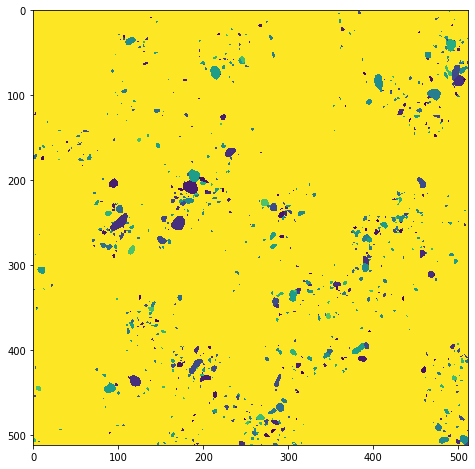

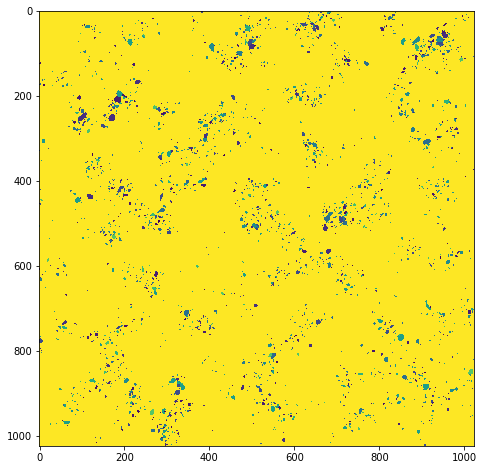

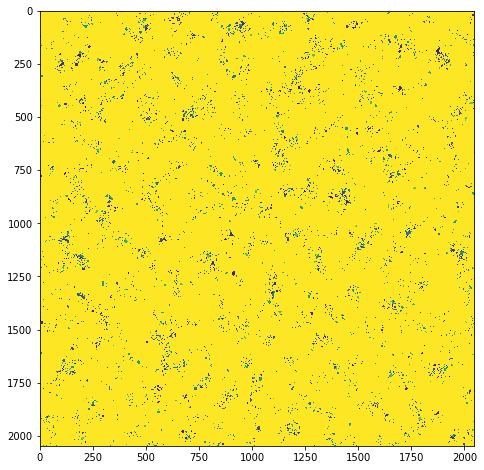

In [139]:
print(np.count_nonzero(world_map))
unique, counts = np.unique(world_map, return_counts=True)
count_dict = dict(zip(unique, counts))
print(count_dict)
print(height * width - counts[-1])

for k, v in oretypes.items():
    print(k, v)
    total = 0
    for t in v:
        total += count_dict[t]
    print('{}: {}'.format(k, total))
        

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(world_map[:512, :512])
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(world_map[:1024, :1024])
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(world_map)


In [ ]:
def filaments(generate=False):
    #octaves = (7, 13, 19, 27, 35, 51, 91)
    octaves = (5, 9, 17, 29, 39, 51, 91)
    gen_height = 2048
    gen_width = 2048

    if generate:
        noise = get_sub_noise(gen_height, gen_width, octaves)
        save_noise('seven_octaves_1024.npz', noise)
    else:
        noise = load_noise('seven_octaves_1024.npz')
    
    normnoise = {k:np.interp(v, (v.min(), v.max()), (0, 1)) for k,v in noise.items()}
    fig, ax = plt.subplots(5, 2, figsize=(12,24))
    for ki, k in enumerate(normnoise.keys()):
        r = ki // 2
        c = ki % 2
        ax[r, c].imshow(normnoise[k])
    ks = list(normnoise.keys())
    filament = np.sqrt(normnoise[ks[-1]]).clip(0.5, 1.0)
#     filament_sum = (normnoise[ks[-1]] + normnoise[ks[-2]]) / 2
#     filament_clip = np.sqrt(filament_sum.clip(0.5, 1.0))
#     filament = np.interp(filament_sum, (filament_sum.min(), filament_sum.max()), (0, 1))
#     anti_filament = 1 - filament_sum.clip(0.0, 0.7)
    ax[3, 1].imshow(filament)
#     ax[4, 0].imshow(anti_filament)
    
    
            
filaments(False)

135


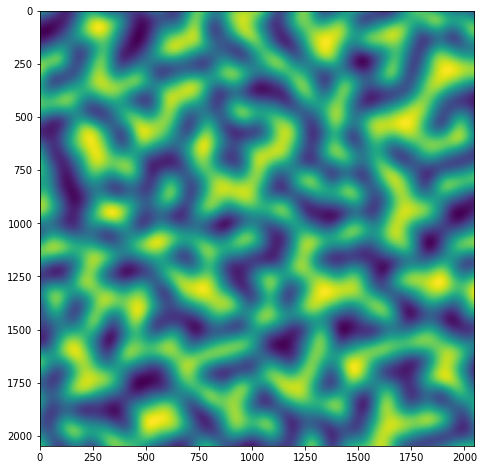

In [144]:
test_noise = get_sub_noise(2048, 2048, (135,))
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(test_noise[135])